<a href="https://colab.research.google.com/github/lbovet8/phys152-2026/blob/main/Projects/HiggsProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import torch

import xgboost
from xgboost import XGBClassifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load data
data = pd.read_csv('/content/drive/My Drive/ML_Project/HIGGS.csv.gz')

In [3]:
# first column is label, all columns after are features
y = data.iloc[:, 0].values
X = data.iloc[:, 1:].values

# 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# separate features into low and high level
X_train_low = X_train[:, :21]
X_test_low = X_test[:, :21]

X_train_high = X_train[:, 21:]
X_test_high = X_test[:, 21:]

In [4]:
print(f"Total Dataset: {len(data)}")

print(f"Training all features shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing all features shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

print(f"Training low features shape: {X_train_low.shape}")
print(f"Testing low features shape: {X_test_low.shape}")

Total Dataset: 10999999
Training all features shape: (8799999, 28), Training labels shape: (8799999,)
Testing all features shape: (2200000, 28), Testing labels shape: (2200000,)
Training low features shape: (8799999, 21)
Testing low features shape: (2200000, 21)
Training high features shape: (8799999, 7)
Testing high features shape: (2200000, 7)


# Visualization of features for both labels

In [8]:
# Take a look at data
print(y_train[0])
print(y_train[3])
print(len(X_train[0]))
print(X_train[0])
print(X_train[0][0])

0.0
1.0
28
[ 0.37077641  2.13001561 -0.19444239  0.24796259  0.10643989  0.63529605
 -1.6230123   1.01799393  0.          1.41200769  1.37649679  1.44023764
  0.          1.71388853 -0.33934987 -0.86614174  0.          1.39569664
  0.28769615 -0.48858672  3.10196137  2.25203609  1.58605218  0.99725837
  0.54030633  0.46727264  1.1294384   0.99767011]
0.3707764148712158


In [24]:
def plot_one_feature(training_input_data, training_output_data, feature_int):
  # accessing data with correct labels and desired feature
  x_data_label_0 = []
  x_data_label_1 = []
  for i in range(len(training_output_data)):
    if training_output_data[i] == 0.0:
      x_data_label_0.append(training_input_data[i][feature_int])
    elif training_output_data[i] == 1.0:
      x_data_label_1.append(training_input_data[i][feature_int])

  # Plot
  plt.figure(figsize=(6, 4))
  plt.hist(x_data_label_0, bins=50, alpha=0.5, color='pink', label='Background')
  plt.hist(x_data_label_1, bins = 50, alpha=0.5, color='purple', label='Signal')
  plt.xlabel('Value of Feature')
  plt.ylabel('Number of Events')
  plt.legend()
  plt.title(f"Feature Nr. {feature_int}")
  plt.show()

In [22]:
def plot_all_features(training_input_data, training_output_data):

    fig, axes = plt.subplots(7, 4, figsize=(16, 21))
    axes = axes.flatten()

    for feature_int in range(28):
        x_data_label_0 = []
        x_data_label_1 = []

        for i in range(len(training_output_data)):
          if training_output_data[i] == 0.0:
            x_data_label_0.append(training_input_data[i][feature_int])
          elif training_output_data[i] == 1.0:
            x_data_label_1.append(training_input_data[i][feature_int])

        axes[feature_int].hist(x_data_label_0, bins=50, alpha=0.5, color='pink', label='Background')
        axes[feature_int].hist(x_data_label_1, bins=50, alpha=0.5, color='purple', label='Signal')

        axes[feature_int].set_title(f"Feature {feature_int}")
        axes[feature_int].tick_params(labelsize=8)

    plt.tight_layout()
    fig.supxlabel("Feature Value", fontsize=14)
    fig.supylabel("Number of Events", fontsize=14)
    plt.show()



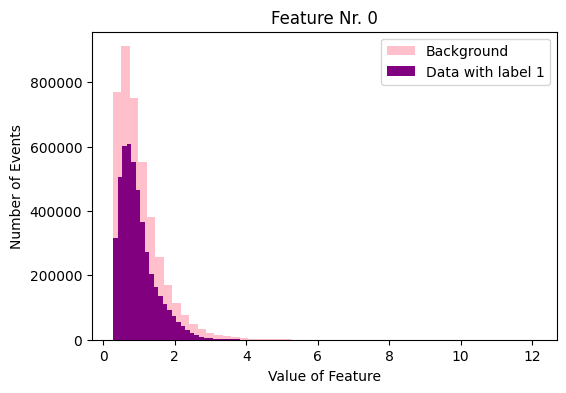

In [23]:
#plot_one_feature(X_train, y_train, 0)

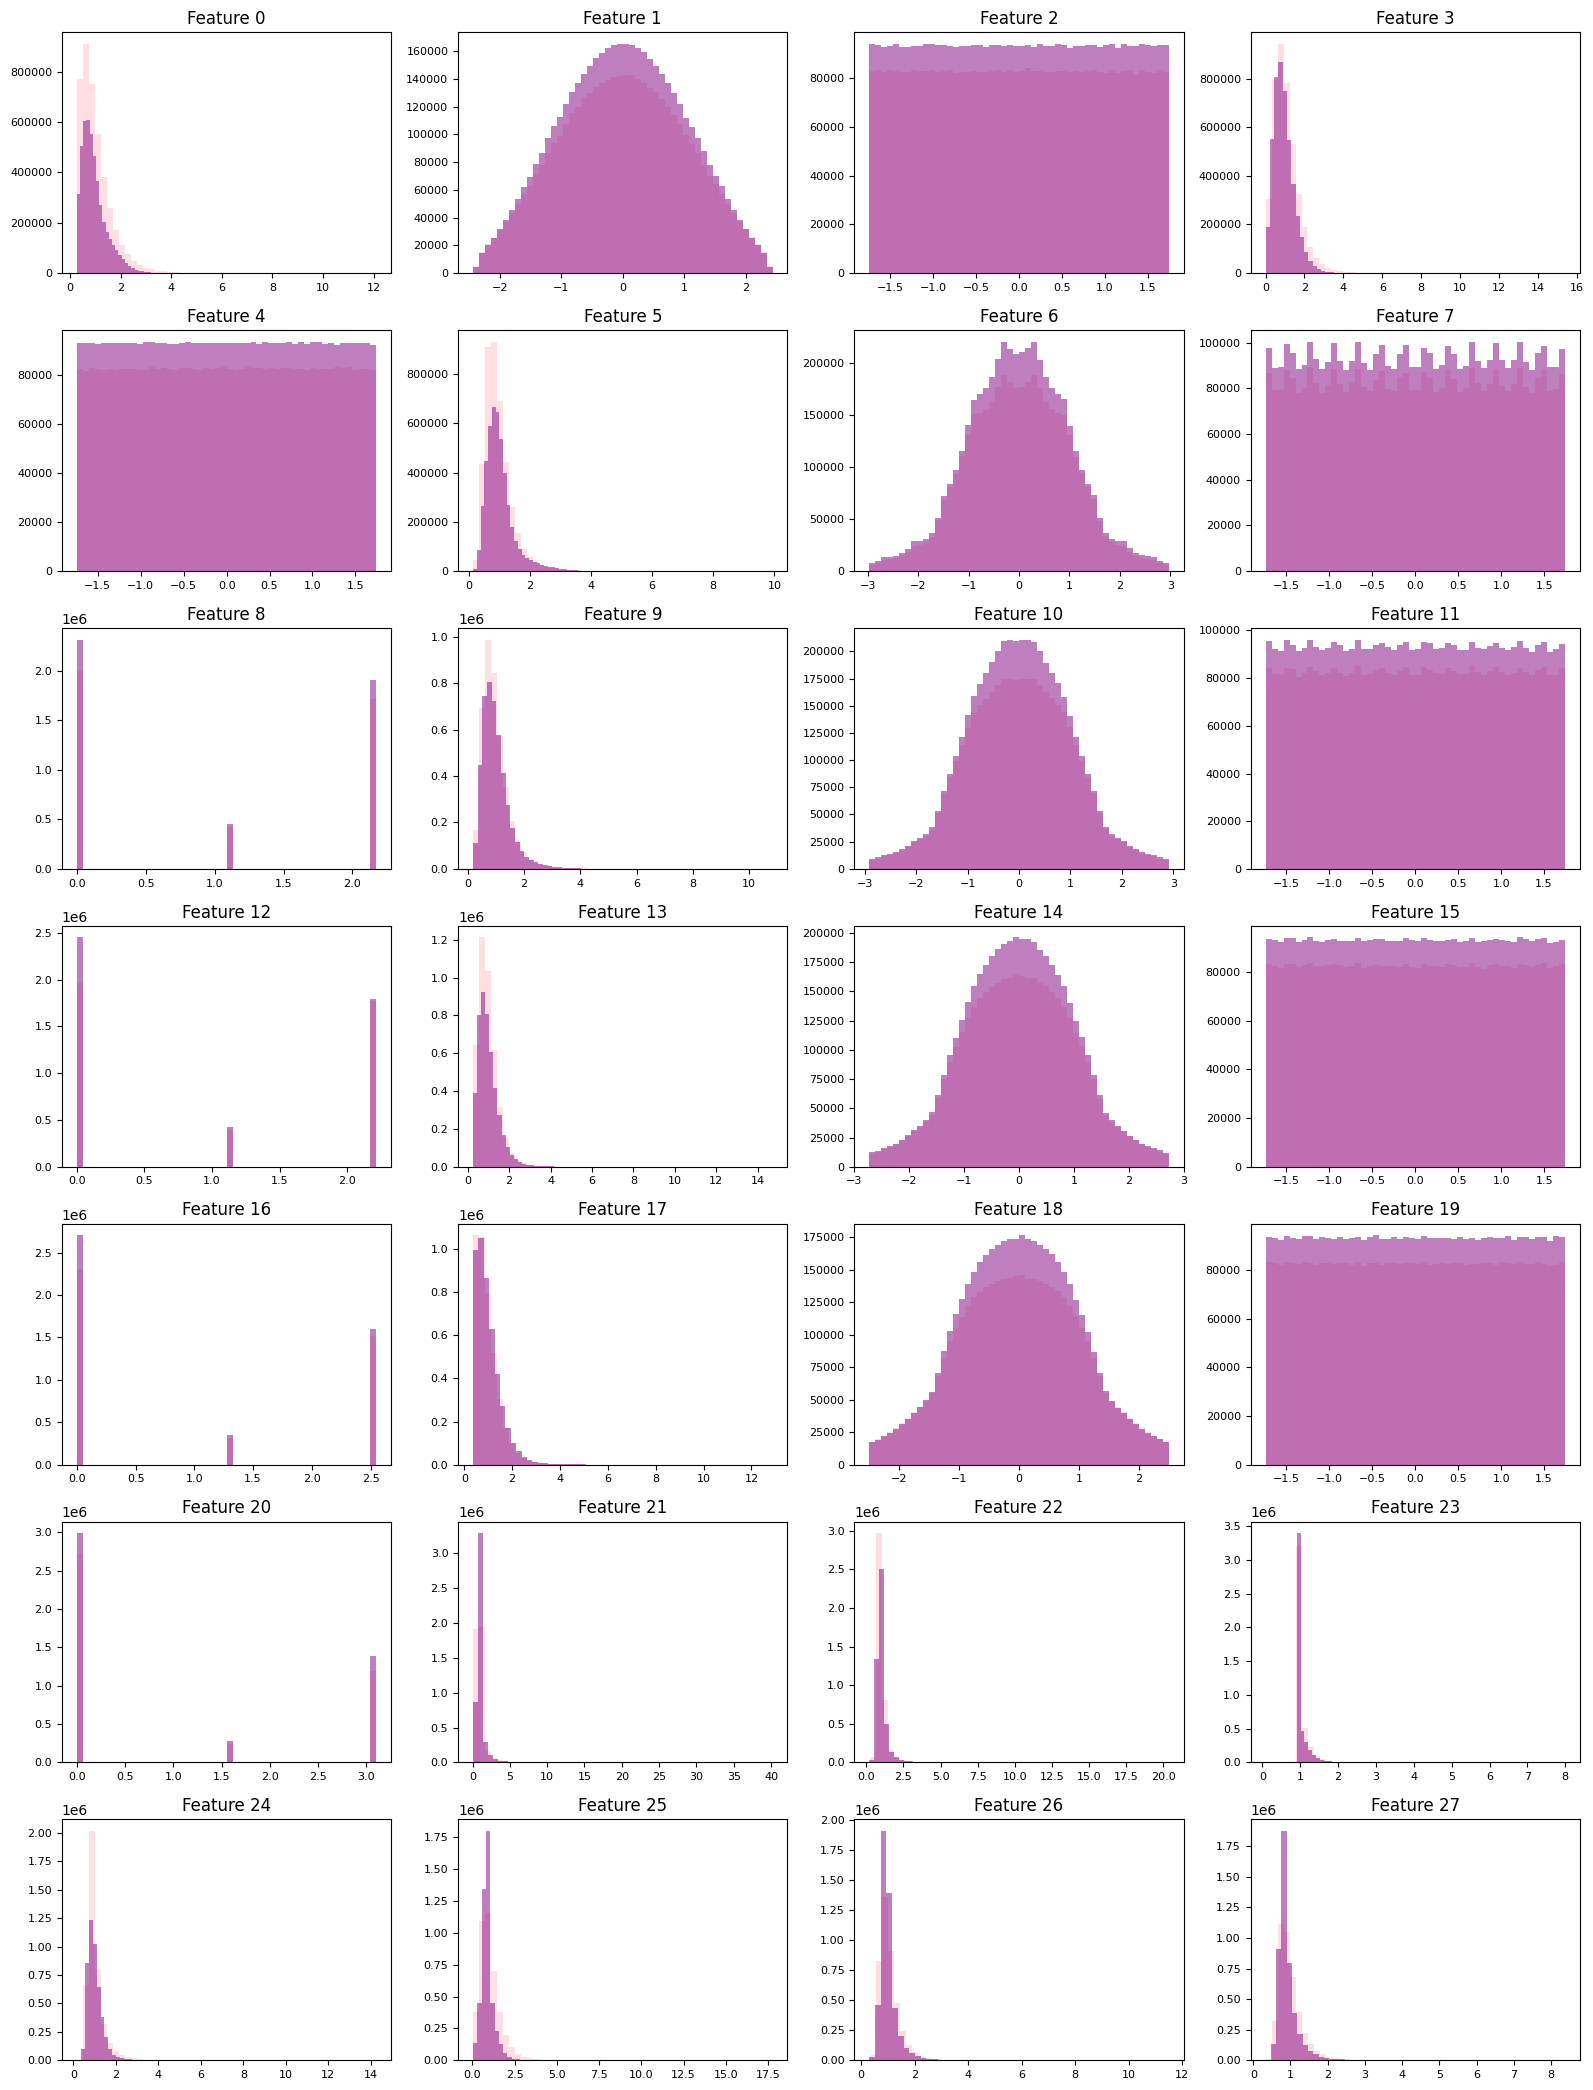

In [25]:
#plot_all_features(X_train, y_train)


# Implement Decision Tree

In [32]:
xgbclf_high = XGBClassifier(n_estimators=5, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
xgbclf_high.fit(X_train, y_train)
# make predictions
#preds = xgbclf_high.predict(X_test)
xgbclf_high.score(X_train,y_train), xgbclf_high.score(X_test,y_test)


(0.6670665530757447, 0.666935909090909)

In [34]:
xgbclf_low = XGBClassifier(n_estimators=5, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
xgbclf_low.fit(X_train_low, y_train)
# make predictions
#preds = xgbclf_high.predict(X_test)
xgbclf_low.score(X_train_low, y_train), xgbclf_low.score(X_test_low,y_test)

(0.5729817696570193, 0.57283)

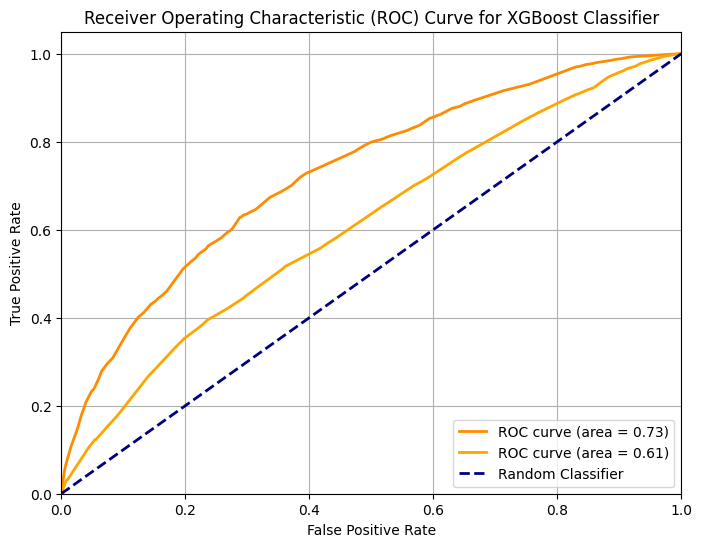

In [37]:
# Get predicted probabilities for the positive class
y_pred_proba_xgbclf_high = xgbclf_high.predict_proba(X_test)[:, 1]
y_pred_proba_xgbclf_low = xgbclf_low.predict_proba(X_test_low)[:, 1]

# Calculate ROC curve
fpr_high, tpr_high, thresholds_high = roc_curve(y_test, y_pred_proba_xgbclf_high)
roc_auc_high = auc(fpr_high, tpr_high)

fpr_low, tpr_low, thresholds_low = roc_curve(y_test, y_pred_proba_xgbclf_low)
roc_auc_low = auc(fpr_low, tpr_low)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_high, tpr_high, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_high:.2f})')
plt.plot(fpr_low, tpr_low, color='orange', lw=2, label=f'ROC curve (area = {roc_auc_low:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()